## Advanced structure solution: parallel process & testing multiple configurations
You should first try the cimetidine structure solution notebook before this one.

In this notebook, you can try solving a structure while:
* testing different spacegroups and adapting the crystal contents (number of independent molecules)
* using multiple parallel process to go faster

This is an example of meta-structure solution, 'meta' meaning that instead if having a single description for the contents of you crystal (spacegroup, number of molecules, atoms or polyhedra), you can try any different combinations using python. It requires a little programming but can be very powerful when several choices for the configuration of your structure are possible.

For this to work you need to install the following packages:
* `multiprocess`
* `ipywidgets` and `py3dmol` (optional)

In [1]:
%matplotlib widget

import os
import sys
import io
import timeit

# Note: we need 'multiprocess' instead of standard multiprocessing because of the
# following issue (specific to ipython or notebooks):
# https://bugs.python.org/issue25053
# https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror
#
# In a python script (not in ipython or a notebook) multiprocessing could be used instead
try:
    from multiprocess import Pool, current_process
except ImportError:
    print("Please install `multiprocess` using 'pip', 'conda' or 'mamba' to run this notebook")
    print()
    sys.exit()

import pyobjcryst
import numpy as np
import matplotlib.pyplot as plt
from pyobjcryst.crystal import *
from pyobjcryst.powderpattern import *
from pyobjcryst.indexing import *
from pyobjcryst.molecule import *
from pyobjcryst.globaloptim import MonteCarlo
from pyobjcryst.io import xml_cryst_file_save_global
try:
    import ipywidgets as widgets
except ImportError:
    widgets = None

try:
    # Get the real number of processor cores available - requires psutil
    # os.sched_getaffinity is only available on some *nix platforms
    import psutil
    nproc = len(os.sched_getaffinity(0)) * psutil.cpu_count(logical=False) // psutil.cpu_count(logical=True)
except:
    nproc = os.cpu_count()

print("Number of processors or cores available: ", nproc)


Number of processors or cores available:  8


### Create powder pattern object, index & fit profile
Same as the cimetidine structure solution notebook, so read that for details

Imported powder pattern: 7699 points, 2theta=  8.010 ->  84.990, step= 0.010
Indexed unit cell:
( 6.83 18.82 10.39  90.0 106.4  90.0 V=1281 MONOCLINIC P, 130.0296630859375)
No background, adding one automatically
Selected PowderPatternDiffraction:    with Crystal:  
Profile fitting finished.
Remember to use SetExtractionMode(False) on the PowderPatternDiffraction object
to disable profile fitting and optimise the structure.
Fit result: Rw=  5.45% Chi2=  33309.27  GoF=    4.33  LLK=  6248.657


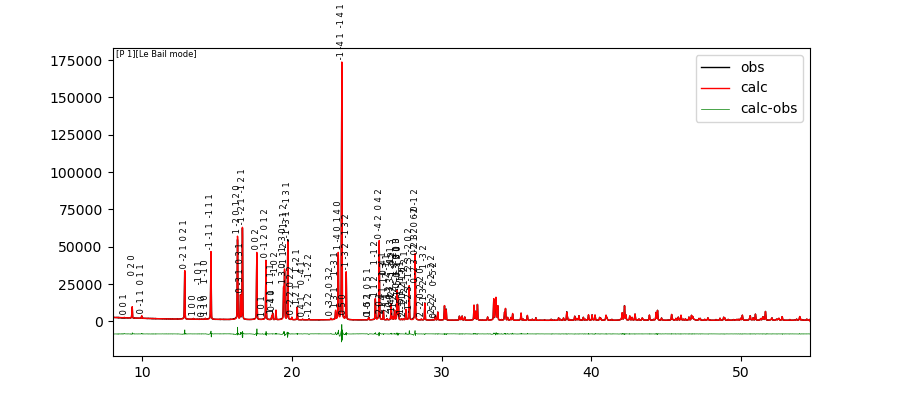

In [2]:
p = PowderPattern()
if not os.path.exists("cime.dat"):
    os.system("curl -O https://raw.githubusercontent.com/vincefn/objcryst/master/Fox/example/tutorial-cimetidine/cime.dat")
p.ImportPowderPatternFullprof("cime.dat")
p.SetWavelength(1.52904)

# Index
pl = p.FindPeaks(1.5, -1, 1000, verbose=False)
if len(pl) > 20:
    pl.resize(20)  # Only keep 20 peaks

ex = quick_index(pl, verbose=False)

print("Indexed unit cell:")
for s in ex.GetSolutions():
    print(s)

# Use solution to create a crystal
uc = ex.GetSolutions()[0][0].DirectUnitCell()
c = Crystal(uc[0], uc[1], uc[2], uc[3], uc[4], uc[5], "P1")
pdiff = p.AddPowderPatternDiffraction(c)

# Fit profile
p.SetMaxSinThetaOvLambda(0.3)
p.quick_fit_profile(auto_background=True,plot=False, init_profile=True,verbose=True)
p.quick_fit_profile(plot=False, init_profile=False, asym=True, displ_transl=True, verbose=False)

# Plot
p.plot(diff=True, fig=None, hkl=True)
print("Fit result: Rw=%6.2f%% Chi2=%10.2f  GoF=%8.2f  LLK=%10.3f" %
      (p.rw * 100, p.chi2, p.chi2/p.GetNbPointUsed(), p.llk))

### Find the spacegroup
We'll use part of the list of possible spacegroups as options to test

In [3]:
p.SetMaxSinThetaOvLambda(0.2)  # Important for stability of profile fit. And faster !
spgex = SpaceGroupExplorer(pdiff)

# NB:verbose C++ output does not appear in a notebook
spgex.RunAll(keep_best=True, update_display=False, fitprofile_p1=False)

for sol in spgex.GetScores():
    #if sol.nGoF > 4 * spgex.GetScores()[0].nGoF:
    if sol.GoF <= 2 * spgex.GetScores()[0].GoF:
        print(sol)

print("Chosen spacegroup (smallest nGoF): ", c.GetSpaceGroup())


Beginning spacegroup exploration... 37 to go...
  (#  1) P 1           : Rwp=  6.72%  GoF=    14.60  nGoF=     3.32  (186 reflections,   0 extinct)
  (#  2) P -1          : Rwp=  6.72%  GoF=    14.60  nGoF=     3.32  (186 reflections,   0 extinct) [same extinctions as:P 1]
  (#  3) P 1 2 1       : Rwp=  6.69%  GoF=    14.47  nGoF=     1.90  (105 reflections,   0 extinct)
  (#  4) P 1 21 1      : Rwp=  6.62%  GoF=    14.12  nGoF=     1.70  (101 reflections,   2 extinct)
  (#  5) C 1 2 1       : Rwp= 62.70%  GoF=  1245.88  nGoF=   311.62  ( 52 reflections,  84 extinct)
  (#  5) A 1 2 1       : Rwp= 62.84%  GoF=  1254.25  nGoF=   314.24  ( 53 reflections,  85 extinct)
  (#  5) I 1 2 1       : Rwp= 60.90%  GoF=  1196.31  nGoF=   246.95  ( 52 reflections,  87 extinct)
  (#  6) P 1 m 1       : Rwp=  6.69%  GoF=    14.47  nGoF=     1.90  (105 reflections,   0 extinct) [same extinctions as:P 1 2 1]
  (#  7) P 1 c 1       : Rwp=  6.58%  GoF=    13.94  nGoF=     1.66  ( 96 reflections,  15 extin

### Setup the 'meta'-structure solution
In the spacegroup search above the first solution `P 1 21/c 1` actually is the correct one, and with its multiplicity (4) only requires a single independent cimetidine molecule in the asymmetric unit cell. But let's proceed as if we did not actually know that.

What we do is:
* download the cimetidine z-matrix
* create a list of the possible spacegroups that we want to test
* create a function which, given a spacegroup, will :
  * apply the spacegroup to the crystal
  * determine the appropriate number of independent molecules (as a function of the multiplicity)
  * optimise for 5 runs and 2 million trials
  * return the solutions using the XML string of the Crystal
* use `multiprocessing` or `multiprocess`  to test the different spacegroups in parallel with multiple processor cores

Note: *this is a generic approach - it would be possible also to completely change the contents of the crystal, e.g. if the number of independent units (atoms, molecule, polyhedra) was unknown, as is often the case for inorganic or metallic structures due to special positions*

In [4]:
# Get the cimetidine z-matrix
if not os.path.exists("cime.fhz"):
    os.system("curl -O https://raw.githubusercontent.com/vincefn/objcryst/master/Fox/example/tutorial-cimetidine/cime.fhz")

# Disable dynamical occupancy correction (no special position expected, usual in organic structures)
c.GetOption(1).SetChoice(0)

# Create the Monte-Carlo object with the crystal and the powder pattern
mc = MonteCarlo()
mc.AddRefinableObj(c)
mc.AddRefinableObj(p)
mc.GetOption("Automatic Least Squares Refinement").SetChoice(2)


# Disable profile fitting for the powder pattern (or nothing gets optimised !)
pdiff.SetExtractionMode(False)


def solve_for_spacegroup(spgname):
    # Set spacegroup
    spg = c.GetSpaceGroup()
    spg.ChangeSpaceGroup(spgname)
    
    # Multiplicity
    mult = spg.GetNbSymmetrics()
    
    # Empty Crystal of existing scatterers (should not be necessary here)
    for i in range(c.GetNbScatterer()):
        c.RemoveScatterer(c.GetScatterer(0))
    
    # Add 4/mult independent cimetidine molecules
    nb_mol = 4//mult
    for i in range(nb_mol):
        m = ImportFenskeHallZMatrix(c,"cime.fhz")
    
    # Disable all display update if not in the Main process-or strange things happen !
    if current_process().name != 'MainProcess':
        # we must do that for the crystal, monte-carlo and powder pattern object
        for o in (c, mc, p):
            o.disable_display_update()
    
    # Run the parallel tempering optimisation
    # We use a loop rather than giving nb_run=5 to MultiRunOptimize, just to write some
    # output regularly to show something is going on.
    # Spacegroups with lower multiplicity will take more time.
    nb_run = 5
    t0 = timeit.default_timer()
    for i in range(nb_run):
        mc.MultiRunOptimize(nb_run=1, nb_step=2e6)
        dt = timeit.default_timer() - t0
        print("Spacegroup: %12s LLK: %12.2f (run #%d/%d) dt=%3.0fs/run (%3.0fs remaining)" % 
              (spgname,mc.GetLogLikelihood(), i+1, nb_run, dt / (i+1), dt/(i+1) * (nb_run-i-1)))
    
    # Extract all solutions as the XML output of the crystal
    vsol = []
    for i in range(mc.GetNbParamSet()):
        mc.RestoreParamSet(i, update_display=False)
        s = c.xml()
        llk = mc.GetLogLikelihood()
        vsol.append({'xml': s, 'llk': llk, 'spg': spgname, 'nb_mol': nb_mol})

    return vsol


Run the tests: **this will take a little while (5 to 20 minutes for each spacegroup, in parallel processes), and is longer for spacegroups with lower multiplicity and not centrosymmetric (more independant atoms)**.

In [5]:
# List of spacegroups to test (this can be larger than the number 
# of availabe processor cores, process will loop over possible spacegroups)
v_spacegroup = ["P 1 21/c 1", "P 1 2/c 1", "P 1 c 1", "P 1 21 1",
                "P 1 2 1", "P 1 m 1", "P 1 21/m 1", "P -1"]

# Use a multiprocess pool to solve in parallel - this should use all available processor cores
print("Solving structures in // - this will take a little while, be patient !")
with Pool(nproc) as pool:
    res = pool.map(solve_for_spacegroup, v_spacegroup)

# Merge all the results
vsol = []
for v in res:
    vsol += v


Solving structures in // - this will take a little while, be patient !
Spacegroup:   P 1 21/c 1 LLK:     18629.53 (run #1/5) dt= 70s/run (280s remaining)
Spacegroup:    P 1 2/c 1 LLK:    226931.17 (run #1/5) dt= 73s/run (293s remaining)
Spacegroup:   P 1 21/m 1 LLK:    257852.04 (run #1/5) dt= 75s/run (298s remaining)
Spacegroup:   P 1 21/c 1 LLK:     18629.53 (run #2/5) dt= 73s/run (218s remaining)
Spacegroup:    P 1 2/c 1 LLK:    226931.17 (run #2/5) dt= 76s/run (227s remaining)
Spacegroup:   P 1 21/m 1 LLK:    194798.29 (run #2/5) dt= 78s/run (233s remaining)
Spacegroup:         P -1 LLK:    115591.05 (run #1/5) dt=170s/run (680s remaining)
Spacegroup:     P 1 21 1 LLK:     90682.94 (run #1/5) dt=199s/run (797s remaining)
Spacegroup:      P 1 c 1 LLK:    102034.33 (run #1/5) dt=203s/run (813s remaining)
Spacegroup:      P 1 2 1 LLK:    171017.02 (run #1/5) dt=216s/run (863s remaining)
Spacegroup:   P 1 21/c 1 LLK:     18629.53 (run #3/5) dt= 72s/run (144s remaining)
Spacegroup:     

### Look at solutions
If you have ipywidgets, just use the dropdown menu to select available solutions

XML: Loading Crystal:
XML: Loading Crystal:(spg:P 1 21/c 1)
Input ScatteringPowerAtom:C(C)
Input ScatteringPowerAtom:N(N)
Input ScatteringPowerAtom:S(S)


interactive(children=(Dropdown(description='solution', options=('# 0    P 1 21/c 1 : 1 mol LLK=    18604.55', …

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Box(children=(VBox(children=(HBox(children=(VBox(children=(FloatRangeSlider(value=(0.0, 1.0), description='Xra…

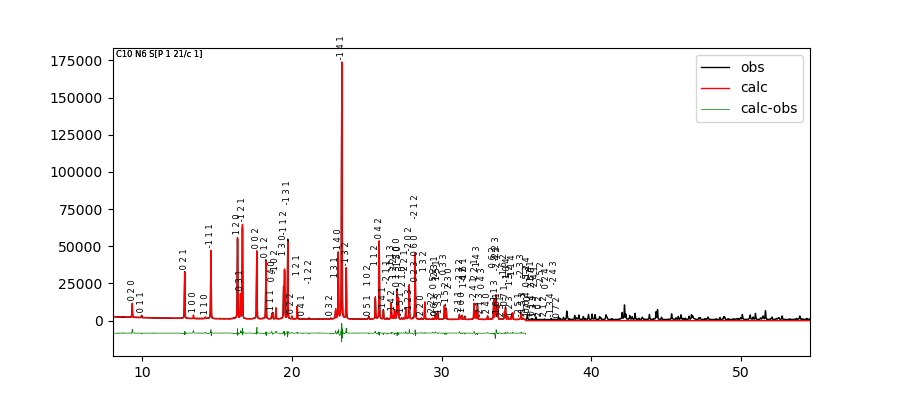

In [6]:
# restore the best solution (first in list)
c.XMLInput(vsol[0]['xml'])

# sort solutions as a function of the log-likelihood
vsol = sorted(vsol, key=lambda sol: sol['llk'])

if widgets is not None:
    v = []
    for i in range(len(vsol)):
        sol = vsol[i]
        v.append("#%2d  %12s : %d mol LLK=%12.2f"%(i, sol['spg'], sol['nb_mol'], sol['llk']))
    w = widgets.Dropdown(options=v, description='Solutions:', disabled=False,)
    def show_solution(solution):
        i = v.index(solution)
        # Crystal display is automatically updated when loaded
        c.XMLInput(vsol[i]['xml'])
        # Update powder pattern display manually
        p.FitScaleFactorForIntegratedRw()
        p.UpdateDisplay()
    widgets.interact(show_solution, solution=v)
else:
    # print solutions
    for i in range(len(vsol)):
        sol = vsol[i]
        print("#%2d  %12s : %d mol LLK=%12.2f"%(i, sol['spg'], sol['nb_mol'], sol['llk']))

# displays - requires ipywidgets for crystal 3D display
display(c.widget_3d())
p.plot(fig=None,diff=True,hkl=True)


### Try some other solutions
If ipywidgets is not shown in the previous cell, load solutions manually

In [7]:
# Crystal display is automatically updated when loaded
c.XMLInput(vsol[2]['xml'])
# Update powder pattern display manually
p.UpdateDisplay()

XML: Loading Crystal:
XML: Loading Crystal:(spg:P 1 21/c 1)
Input ScatteringPowerAtom:C(C)
Input ScatteringPowerAtom:N(N)
Input ScatteringPowerAtom:S(S)


### Save the selected result to CIF and Fox (.xmlgz) formats
All the solutions (or just the best ones) could be saved automatically that way by looping over the results

In [8]:
# Save result so it can be opened by Fox
xml_cryst_file_save_global('result.xmlgz')
# Also export to the CIF format
c.CIFOutput("result.cif")